# Inference with exported learner for segmentation tasks 

In [1]:
#all_skip
from fastMONAI.vision_all import *
from IPython.display import clear_output

from monai.apps import DecathlonDataset
import torchio as tio

In [2]:
#task = 'Task09_Spleen'
task = 'Task01_BrainTumour'

In [3]:
path = Path.cwd()/'..'/'data'

In [4]:
test_data = DecathlonDataset(root_dir=path, task=task, section="test", download=True,
                                 cache_num=0, num_workers=3) 

2022-08-31 21:03:10,549 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2022-08-31 21:03:10,549 - INFO - File exists: /home/arvid/GitHub/my_fastMONAI/nbs/../data/Task01_BrainTumour.tar, skipped downloading.
2022-08-31 21:03:10,550 - INFO - Non-empty folder exists in /home/arvid/GitHub/my_fastMONAI/nbs/../data/Task01_BrainTumour, skipped extracting.


In [5]:
test_imgs = [data['image'] for data in test_data.data]

In [69]:
def inference(learn_inf, reorder, resample, fn:str, save_path:(str,Path)=None): 
    '''
    Predict on new data using exported model
    '''         
    #Get original information for storing the prediction in the same size as the original volume later. 
    img, org_metadata = med_img_reader(fn,reorder=reorder, resample=resample, only_tensor=False, dtype=MedImage)
               
    
    pred, *_ = learn_inf.predict(img.data);
    
    # crop or pad to input size
    pred_mask = do_pad_or_crop(pred.float(), img.shape[1:], padding_mode=0, mask_name=None)
    img.set_data(pred_mask)
        
        
    # back to resampled size
    if 'spacing' in org_metadata: 
        transform = tio.Resample(org_metadata['spacing'], image_interpolation='nearest')
        img = transform(img)
        
        #if diff between orignal size and resampled size
        diff = np.array(img.shape[1:]) - np.array(org_metadata['org_size'])
        if np.sum(diff) != 0: 
            print('Diff between orignal shape and resampled mask:', diff)
            # diff = np.where(diff != 0, 0.01, diff) 
            # transform.target = org_spacing + diff 
            # img = transform(img)
        
    if 'orientation' in org_metadata:
        transform = tio.ToCanonical(org_metadata['orientation'])
        img = transform(o)
        
    
    if save_path is not None:
        # print(f"Path(fn)[-1]: {Path(fn)}")
        save_fn = 'pred_' + Path(fn).name  # arvidl: Path(fn)[-1] --> 'PosixPath' object is not subscriptable
        save_fn = Path(save_path)/save_fn
        img.save(save_fn)
    
    return img

In [70]:
learn_inf = load_learner('braintumor_model.pkl', cpu=False);

In [71]:
reorder, resample = load_variables(pkl_fn='vars.pkl')
reorder, resample

(False, [1.25, 1.25, 1.37])

In [72]:
save_path = Path('../data/results/braintumor')
save_path.mkdir(parents=True, exist_ok=True)

In [73]:
idx = 3
fn = test_imgs[idx]

In [74]:
mask = inference(learn_inf, reorder, resample, fn, save_path=save_path)

Diff between orignal shape and resampled mask: [0 0 2]


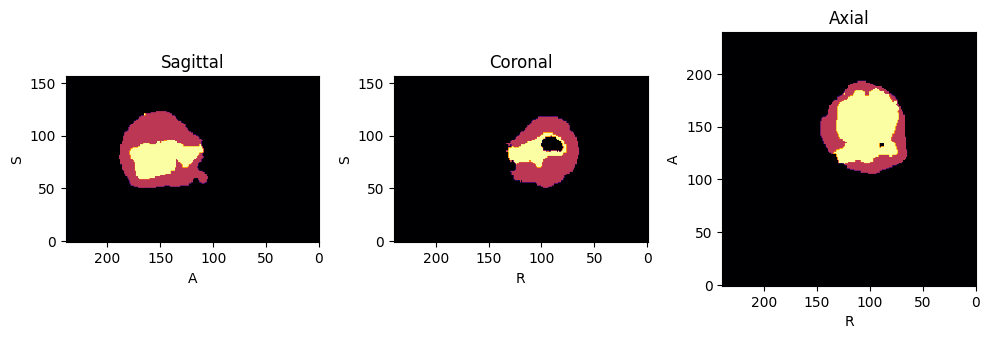

In [75]:
mask.plot(figsize=(10,10),cmap='inferno')

In [76]:
mask.to_gif(duration=10,output_path=save_path/'example.gif', axis=0)

In [79]:
# !xdg-open ../data/results/braintumor/example.gif

<img src="../data/results/braintumor/example.gif" width="250" align="center">